In [53]:
import os
import torch
import pandas as pd
import itertools
import numpy as np
import ipywidgets as widgets
from napatrackmater.Trackvector import (
    SHAPE_DYNAMIC_FEATURES
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import seaborn as sns

In [54]:
dataset_name = 'Third'
home_folder = '/home/debian/jz/'
channel = 'nuclei_'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tracklet_length = 25
normalized_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}predicted_morpho_feature_attention_shallowest_litest.csv')
print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)
n_components = 10
deltat = 10
poly_order = 5
class_map_gbr = {
        0: "Basal",
        1: "Radial",
        2: "Goblet"
    }

reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Third_Dataset_Analysis/nuclei_membrane_tracking/dataframes/goblet_basal_dataframe_normalized_nuclei_predicted_morpho_feature_attention_shallowest_litest.csv


In [55]:
all_trackmate_ids = [trackid  for trackid in tracks_dataframe['TrackMate Track ID'].unique()]
result_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
variance_summary = {cell_type: {} for cell_type in class_map_gbr.values()}
unique_time_points = tracks_dataframe['t'].unique()

for time_point in unique_time_points:
    time_data = tracks_dataframe[tracks_dataframe['t'] == time_point]

    for cell_type in class_map_gbr.values():
        cell_type_data = time_data[time_data['Cell_Type'] == cell_type]

        if not cell_type_data.empty:
            
            features_list = []
            track_id_list = []  # Lookup table for track IDs
            
            for track_id in cell_type_data['Track ID'].unique():
                track_features = cell_type_data[cell_type_data['Track ID'] == track_id][SHAPE_DYNAMIC_FEATURES].to_numpy()
                features_list.append(track_features)
                track_id_list.extend([track_id] * track_features.shape[0])  # Keep track ID for each row

            concatenated_features = np.vstack(features_list)
            
            if concatenated_features.shape[0] > n_components:  
                pca = PCA(n_components=n_components)
                principal_components = pca.fit_transform(concatenated_features)
                explained_variance = pca.explained_variance_ratio_

                # Store the total variance explained for each cell type and time point
                total_variance_explained = sum(explained_variance)
                if time_point not in variance_summary[cell_type]:
                    variance_summary[cell_type][time_point] = total_variance_explained

                if time_point not in result_dict[cell_type]:
                    result_dict[cell_type][time_point] = []

                # Append PCA result and track ID mapping
                result_dict[cell_type][time_point].append({
                    'principal_components': principal_components,
                    'track_ids': track_id_list  
                })
print(variance_summary)






{'Basal': {0.0: 0.9997819186605721, 1.0: 0.9818670055514045, 2.0: 0.9771845931039566, 3.0: 0.9797214862145113, 4.0: 0.9653563074031322, 5.0: 0.9564277195124463, 6.0: 0.9563800444931231, 7.0: 0.9545532689262441, 8.0: 0.9593300065343336, 9.0: 0.9495159365848995, 10.0: 0.953091671924257, 11.0: 0.946038199698348, 12.0: 0.9450285690368333, 13.0: 0.9576498870869252, 14.0: 0.9574411743169426, 15.0: 0.9483667235224426, 16.0: 0.9563263499518092, 17.0: 0.9498104444547486, 18.0: 0.9545770779912861, 19.0: 0.9585485594639029, 20.0: 0.9671028135927081, 21.0: 0.9498251280017275, 22.0: 0.9544496942088181, 23.0: 0.9595187571971869, 24.0: 0.9551916970748942, 25.0: 0.9784823245220827, 26.0: 0.9682572986776945, 27.0: 0.952385820165251, 28.0: 0.9653542567624044, 29.0: 0.9574182337730712, 30.0: 0.9589803761949808, 31.0: 0.9501622639208849, 32.0: 0.9487203645620071, 33.0: 0.9560247642846478, 34.0: 0.9459571366698245, 35.0: 0.9580826920588785, 36.0: 0.9503625654397377, 37.0: 0.9519983209534254, 38.0: 0.954073

In [63]:
derivative_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
derivative_square_dict = {cell_type: {} for cell_type in class_map_gbr.values()}

norm_diff_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
for cell_type in class_map_gbr.values():

    for time_idx, time_point in enumerate(unique_time_points[:-1]):  
        if time_idx + deltat < max(unique_time_points):
                next_time_point = unique_time_points[time_idx + deltat]

                if time_point in result_dict[cell_type] and next_time_point in result_dict[cell_type]:
                    # Extract the PCA results and track IDs for both time points
                    curr_data = result_dict[cell_type][time_point][0]
                    next_data = result_dict[cell_type][next_time_point][0]

                    curr_features = curr_data['principal_components']  # (N, F)
                    next_features = next_data['principal_components']  # (M, F)

                    curr_track_ids = np.array(curr_data['track_ids'])  # (N,)
                    next_track_ids = np.array(next_data['track_ids'])  # (M,)

                    # Find matching track IDs between the two time points
                    common_track_ids, curr_indices, next_indices = np.intersect1d(
                        curr_track_ids, next_track_ids, return_indices=True
                    )

                    if len(common_track_ids) == 0:
                        continue  # Skip if no matching track IDs

                    # Align the features to the exact same track IDs using indices
                    aligned_curr_features = curr_features[curr_indices]
                    aligned_next_features = next_features[next_indices]

                    # Compute the norm differences
                    curr_norms = np.linalg.norm(aligned_curr_features, axis=1)  # Norms of current features
                    next_norms = np.linalg.norm(aligned_next_features, axis=1)  # Norms of next features
                    norm_differences = next_norms - curr_norms

                    # Compute the time derivative
                    time_derivative = (aligned_next_features - aligned_curr_features) 
                    # Initialize dictionaries if they don't exist for the time point
                    if time_point not in derivative_dict[cell_type]:
                        derivative_dict[cell_type][time_point] = []
                        derivative_square_dict[cell_type][time_point] = []
                        norm_diff_dict[cell_type][time_point] = []

                    # Store the derivatives and norm differences
                    derivative_dict[cell_type][time_point].append({'principal_components': time_derivative/ deltat, 'track_id_list': next_features })
                    derivative_square_dict[cell_type][time_point].append({ 'principal_components': time_derivative * time_derivative * 0.5/ deltat, 'track_id_list': next_features  })
                    norm_diff_dict[cell_type][time_point].append({ 'principal_components': norm_differences, 'track_id_list': next_features  })


In [57]:

def plot_pcs_density_and_stats(result_dict, n_components=5, selected_pc=1, title='Density and Stats of PC1 Across Cell Types'):
    if selected_pc < 1 or selected_pc > n_components:
        print(f"Invalid principal component number. Please choose a number between 1 and {n_components}.")
        return

    cell_types = [cell_type for cell_type in class_map_gbr.values() if cell_type in result_dict]
    n_cell_types = len(cell_types)

    # Set up the subplot grid
    n_rows = int(np.ceil(n_cell_types))
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows), constrained_layout=True)

    # Flatten axes for easy iteration
    axes = axes.reshape(-1, 3)

    # Loop over each cell type and plot its density and stats
    for idx, cell_type in enumerate(cell_types):
        # Density Plot
        ax_density = axes[idx, 0]

        all_data = []
        all_labels = []

        for time_point in sorted(result_dict[cell_type].keys()):
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)

            pc_values = pcs[:, selected_pc - 1]

            all_data.extend(pc_values)
            all_labels.extend([f'Time {time_point}'] * len(pc_values))

        df_density = pd.DataFrame({'PC Value': all_data, 'Time Point': all_labels})
        sns.kdeplot(
            data=df_density,
            x='PC Value',
            hue='Time Point',
            ax=ax_density,
            palette='tab20',
            linewidth=1.5,
            legend=False
        )
        ax_density.set_title(f' PC{selected_pc} for {cell_type}', fontsize=14)
        ax_density.set_xlabel(f'PC{selected_pc} Value', fontsize=12)
        ax_density.set_ylabel('Density', fontsize=12)

        # Variance Plot (Line Plot)
        ax_stats = axes[idx, 1]
        ax_mean = axes[idx, 2]

        time_points = sorted(result_dict[cell_type].keys())
        variances = []
        means = [] 
        for time_point in time_points:
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)
            pc_values = pcs[:, selected_pc - 1]

            variances.append(np.var(pc_values))
            means.append(np.mean(pc_values))

          # Fitting polynomial to variances and means
        variance_poly_coeff = np.polyfit(time_points, variances, poly_order)
        mean_poly_coeff = np.polyfit(time_points, means, poly_order)
        
        # Evaluate the polynomial at the given time points
        variances = np.polyval(variance_poly_coeff, time_points)
        means = np.polyval(mean_poly_coeff, time_points)    

        # Plot variance using lineplot (instead of errorbar)
        df_variance = pd.DataFrame({'Time Point': time_points, 'Variance': variances, 'Mean': means})
        sns.lineplot(data=df_variance, x='Time Point', y='Variance', marker='o', ax=ax_stats)
        ax_stats.set_title(f'Variance of PC{selected_pc} for {cell_type}', fontsize=14)
        ax_stats.set_xlabel('Time', fontsize=12)
        ax_stats.set_ylabel(f'PC{selected_pc} Variance', fontsize=12)

        sns.lineplot(data=df_variance, x='Time Point', y='Mean', marker='o', ax=ax_mean)
        ax_mean.set_title(f'Mean of PC{selected_pc} for {cell_type}', fontsize=14)
        ax_mean.set_xlabel('Time', fontsize=12)
        ax_mean.set_ylabel(f'PC{selected_pc} Mean', fontsize=12)

    # Turn off unused subplots
    for idx in range(n_cell_types, axes.shape[0]):
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
        axes[idx, 2].axis('off')

    # Add a global title
    fig.suptitle(title, fontsize=16)
    plt.show()


def plot_all_pcs_density_and_stats(result_dict,  title='Density and Stats of PC1 Across Cell Types'):
   

    cell_types = [cell_type for cell_type in class_map_gbr.values() if cell_type in result_dict]
    n_cell_types = len(cell_types)

    # Set up the subplot grid
    n_rows = int(np.ceil(n_cell_types))
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows), constrained_layout=True)

    # Flatten axes for easy iteration
    axes = axes.reshape(-1, 3)

    # Loop over each cell type and plot its density and stats
    for idx, cell_type in enumerate(cell_types):
        # Density Plot
        ax_density = axes[idx, 0]

        all_data = []
        all_labels = []

        for time_point in sorted(result_dict[cell_type].keys()):
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)

            pc_values = np.linalg.norm(pcs, axis=1)

            all_data.extend(pc_values)
            all_labels.extend([f'Time {time_point}'] * len(pc_values))

        df_density = pd.DataFrame({'PC Value': all_data, 'Time Point': all_labels})
        sns.kdeplot(
            data=df_density,
            x='PC Value',
            hue='Time Point',
            ax=ax_density,
            palette='tab20',
            linewidth=1.5,
            legend=False
        )
        ax_density.set_title(f' all PC for {cell_type}', fontsize=14)
        ax_density.set_xlabel(f'all PC Value', fontsize=12)
        ax_density.set_ylabel('Density', fontsize=12)

        # Variance Plot (Line Plot)
        ax_stats = axes[idx, 1]
        ax_mean = axes[idx, 2]

        time_points = sorted(result_dict[cell_type].keys())
        variances = []
        means = [] 
        for time_point in time_points:
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)
            pc_values = np.linalg.norm(pcs, axis=1)

            variances.append(np.var(pc_values))
            means.append(np.mean(pc_values))
            
         # Fitting polynomial to variances and means
        variance_poly_coeff = np.polyfit(time_points, variances, poly_order)
        mean_poly_coeff = np.polyfit(time_points, means, poly_order)
        
        # Evaluate the polynomial at the given time points
        variances = np.polyval(variance_poly_coeff, time_points)
        means = np.polyval(mean_poly_coeff, time_points)
        # Plot variance using lineplot (instead of errorbar)
        df_variance = pd.DataFrame({'Time Point': time_points, 'Variance': variances, 'Mean': means})
        sns.lineplot(data=df_variance, x='Time Point', y='Variance', marker='o', ax=ax_stats)
        ax_stats.set_title(f'Variance of all PC for {cell_type}', fontsize=14)
        ax_stats.set_xlabel('Time', fontsize=12)
        ax_stats.set_ylabel(f'all PC Variance', fontsize=12)

        sns.lineplot(data=df_variance, x='Time Point', y='Mean', marker='o', ax=ax_mean)
        ax_mean.set_title(f'Mean of all PC for {cell_type}', fontsize=14)
        ax_mean.set_xlabel('Time', fontsize=12)
        ax_mean.set_ylabel(f'all PC Mean', fontsize=12)

    # Turn off unused subplots
    for idx in range(n_cell_types, axes.shape[0]):
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
        axes[idx, 2].axis('off')

    # Add a global title
    fig.suptitle(title, fontsize=16)
    plt.show()    




def plot_fluctuation_dissipation(result_dict, norm_dict, title='Fluctuation-Dissipation Plot'):
    
    

    cell_types = [cell_type for cell_type in class_map_gbr.values() if cell_type in result_dict]
    n_cell_types = len(cell_types)

    # Set up the subplot grid
    n_rows = int(np.ceil(n_cell_types))
    fig, axes = plt.subplots(n_rows, 2, figsize=(18, 6 * n_rows), constrained_layout=True)

    # Flatten axes for easy iteration
    axes = axes.reshape(-1, 2)

    # Loop over each cell type and plot its density and stats
    for idx, cell_type in enumerate(cell_types):


        ax_stats = axes[idx, 0]
        ax_mean = axes[idx, 1]

        time_points = sorted(result_dict[cell_type].keys())
        variances = []
        means = [] 

        norm_variances = []
        norm_means = []
        for time_point in time_points:
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  
            #pc_values = pcs[:, selected_pc - 1]
            pc_values = np.linalg.norm(pcs, axis=1)

            data_norm = norm_dict[cell_type][time_point][0]
            norms = data_norm['principal_components']

            variances.append(np.var(pc_values))
            means.append(np.mean(pc_values))

            norm_variances.append(np.var(norms))
            norm_means.append(np.mean(norms))

      
        
        # Fitting polynomial to variances and means
        variance_poly_coeff = np.polyfit(time_points, variances, poly_order)
        mean_poly_coeff = np.polyfit(time_points, means, poly_order)
        
        norm_variance_poly_coeff = np.polyfit(time_points, norm_variances, poly_order)
        norm_mean_poly_coeff = np.polyfit(time_points, norm_means, poly_order)

        # Evaluate the polynomial at the given time points
        variances = np.polyval(variance_poly_coeff, time_points)
        means = np.polyval(mean_poly_coeff, time_points)
        
        norm_variances = np.polyval(norm_variance_poly_coeff, time_points)
        norm_means = np.polyval(norm_mean_poly_coeff, time_points)

        # Plot variance using lineplot (instead of errorbar)
        df_variance = pd.DataFrame({'Time Point': time_points, 'Variance': variances, 'Mean': means})
        sns.lineplot(data=df_variance, x='Time Point', y='Variance', ax=ax_stats)

        sns.lineplot(data=df_variance, x='Time Point', y='Mean', marker='o', ax=ax_mean)


        df_variance = pd.DataFrame({'Time Point': time_points, 'Variance': norm_variances, 'Mean': norm_means})
        sns.lineplot(data=df_variance, x='Time Point', y='Variance', ax=ax_stats)
        ax_stats.set_title(f'Variance of Diffusion constant, Norm Diff for {cell_type}', fontsize=14)
        ax_stats.set_xlabel('Time', fontsize=12)
        ax_stats.set_ylabel(f' Variance', fontsize=12)

        sns.lineplot(data=df_variance, x='Time Point', y='Mean', ax=ax_mean)
        ax_mean.set_title(f'Mean of Diffusion constant, Norm Diff for {cell_type}', fontsize=14)
        ax_mean.set_xlabel('Time', fontsize=12)
        ax_mean.set_ylabel(f' Mean', fontsize=12)
        

    # Turn off unused subplots
    for idx in range(n_cell_types, axes.shape[0]):
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')

    # Add a global title
    fig.suptitle(title, fontsize=16)
    plt.show()


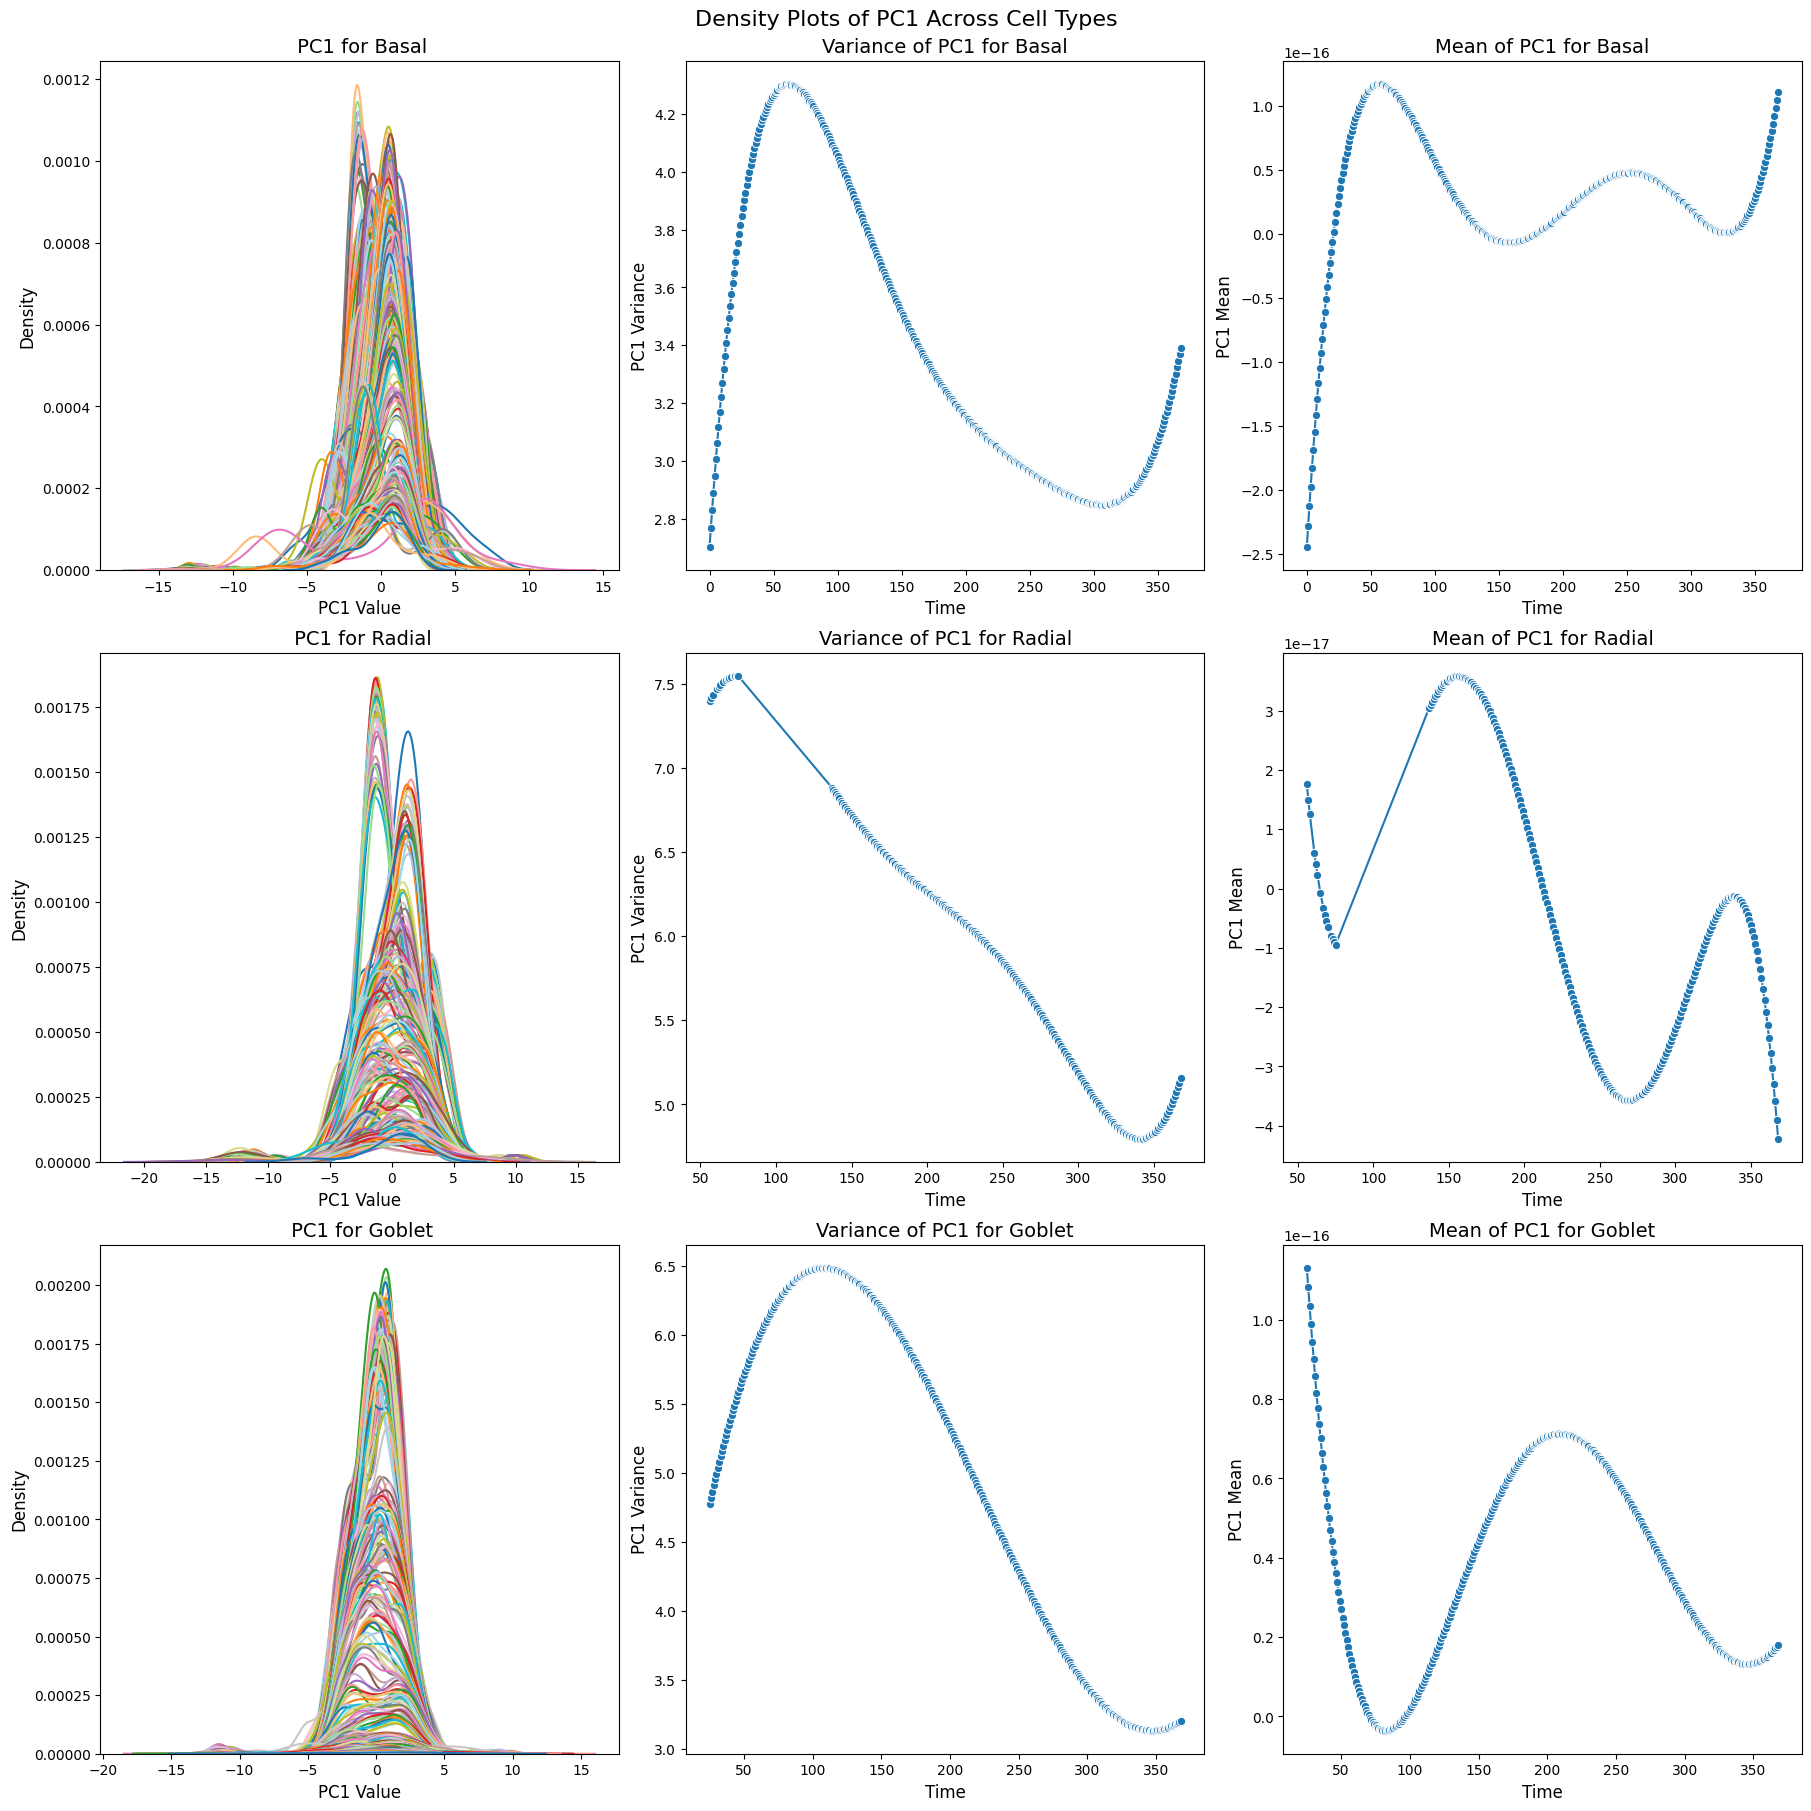

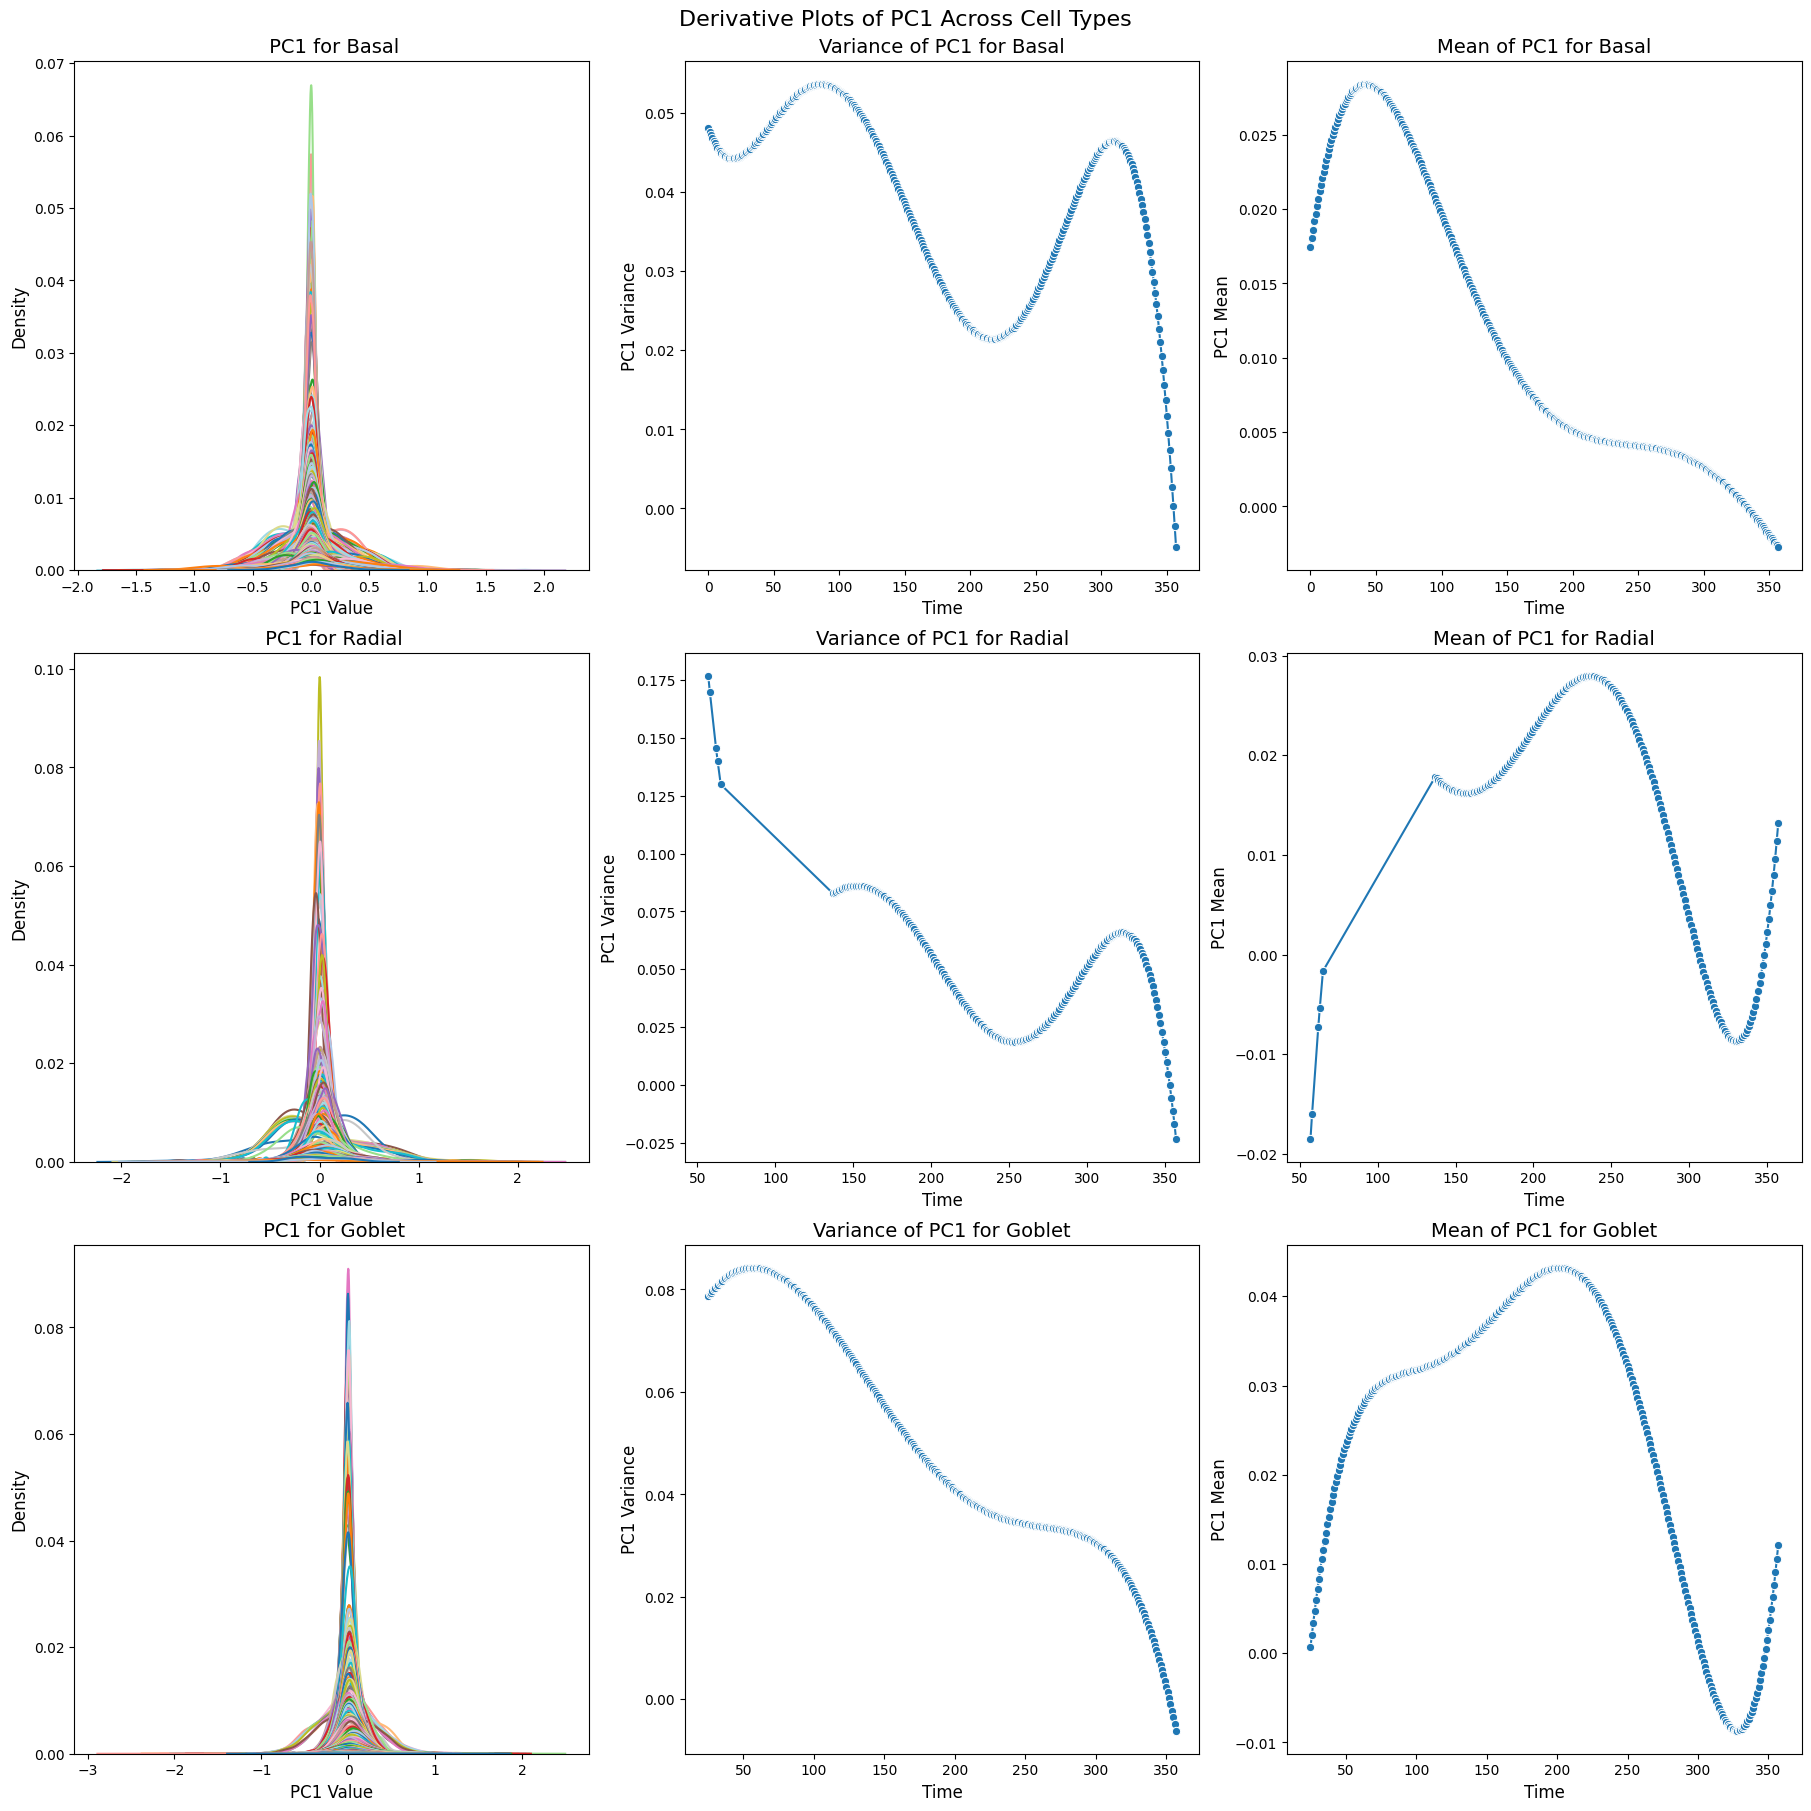

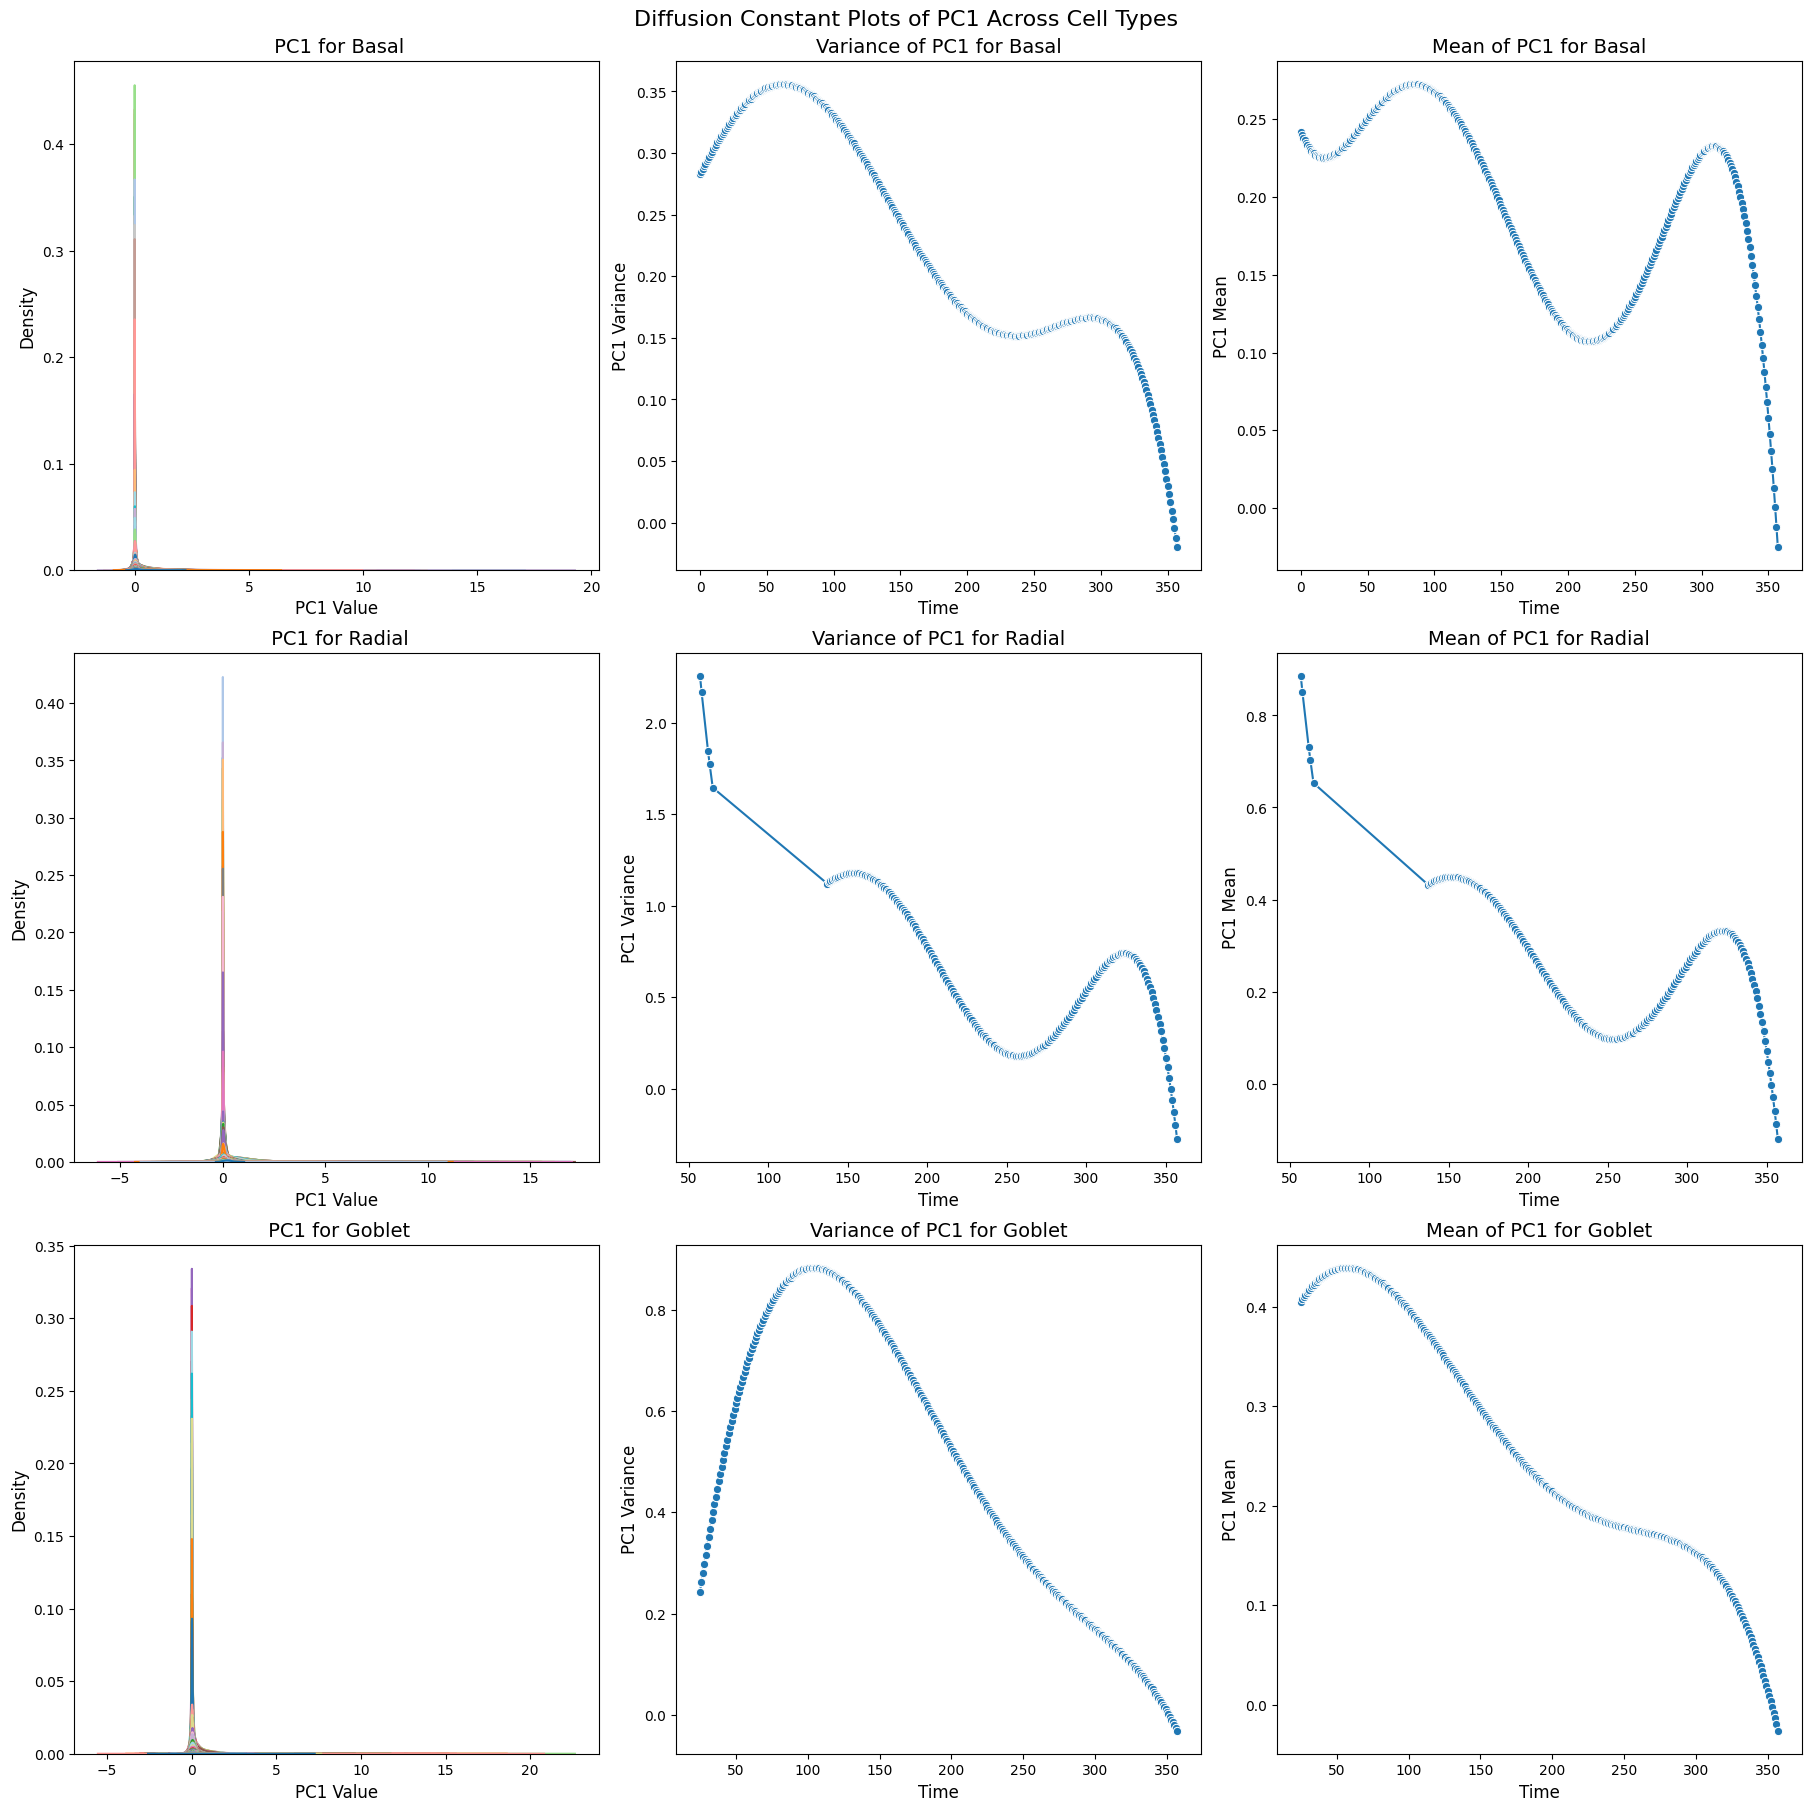

In [58]:
plot_pcs_density_and_stats(result_dict, n_components, title = 'Density Plots of PC1 Across Cell Types')

plot_pcs_density_and_stats(derivative_dict, n_components, title = 'Derivative Plots of PC1 Across Cell Types')

plot_pcs_density_and_stats(derivative_square_dict, n_components, title = 'Diffusion Constant Plots of PC1 Across Cell Types')




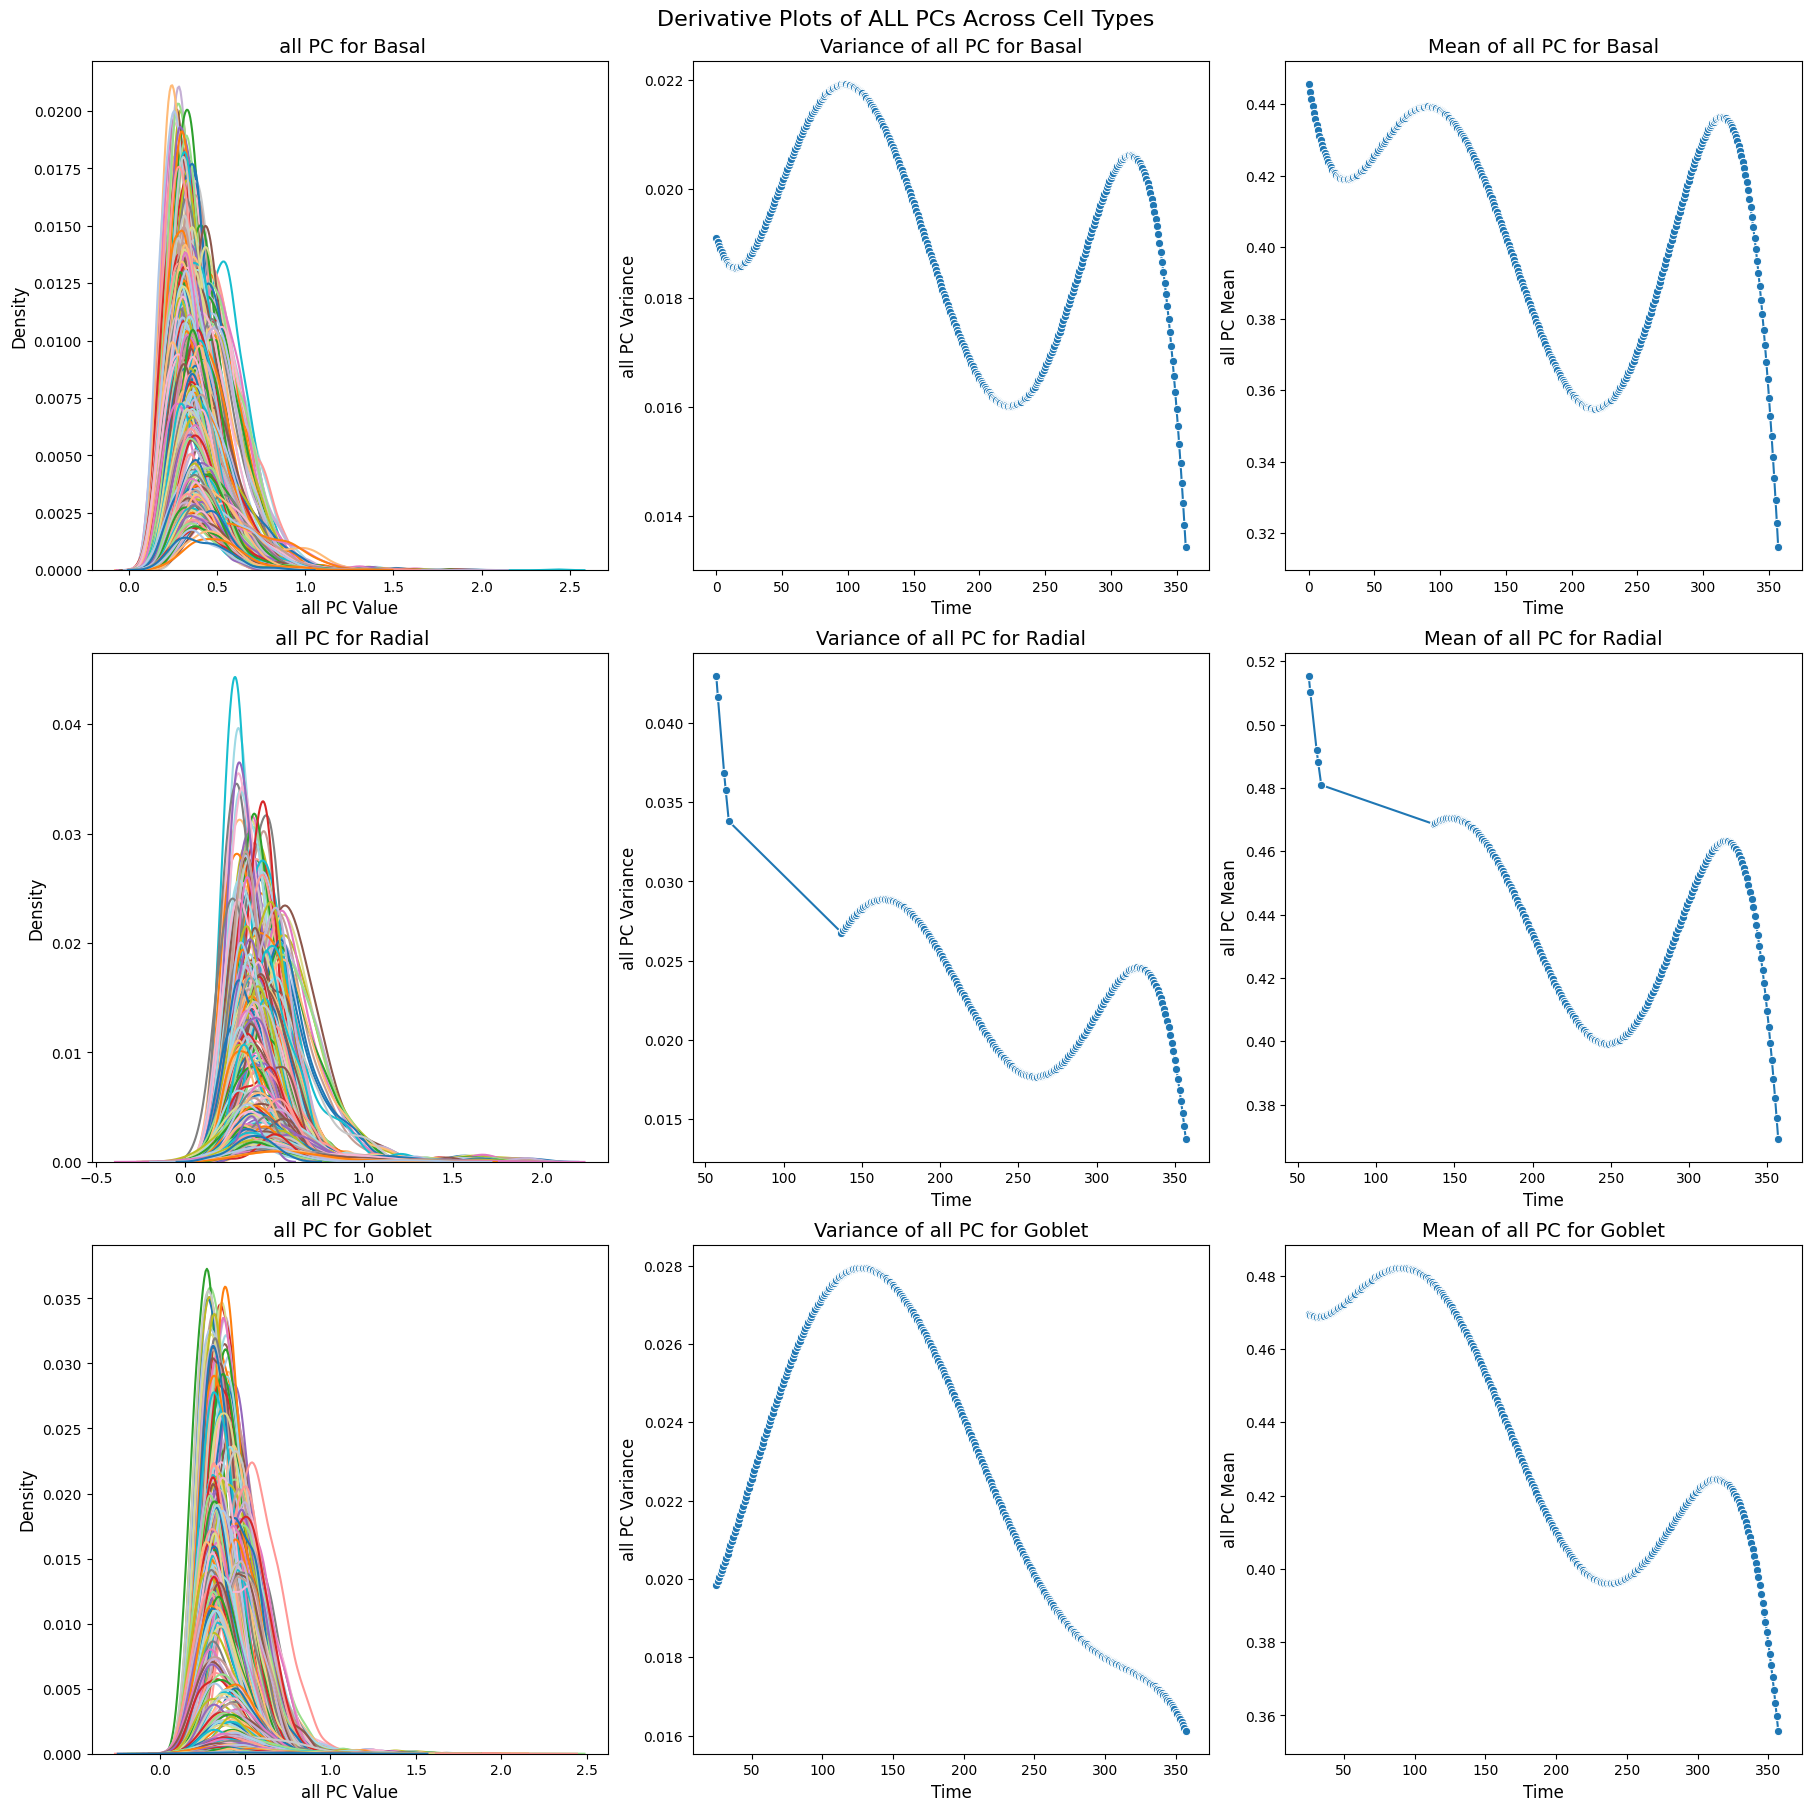

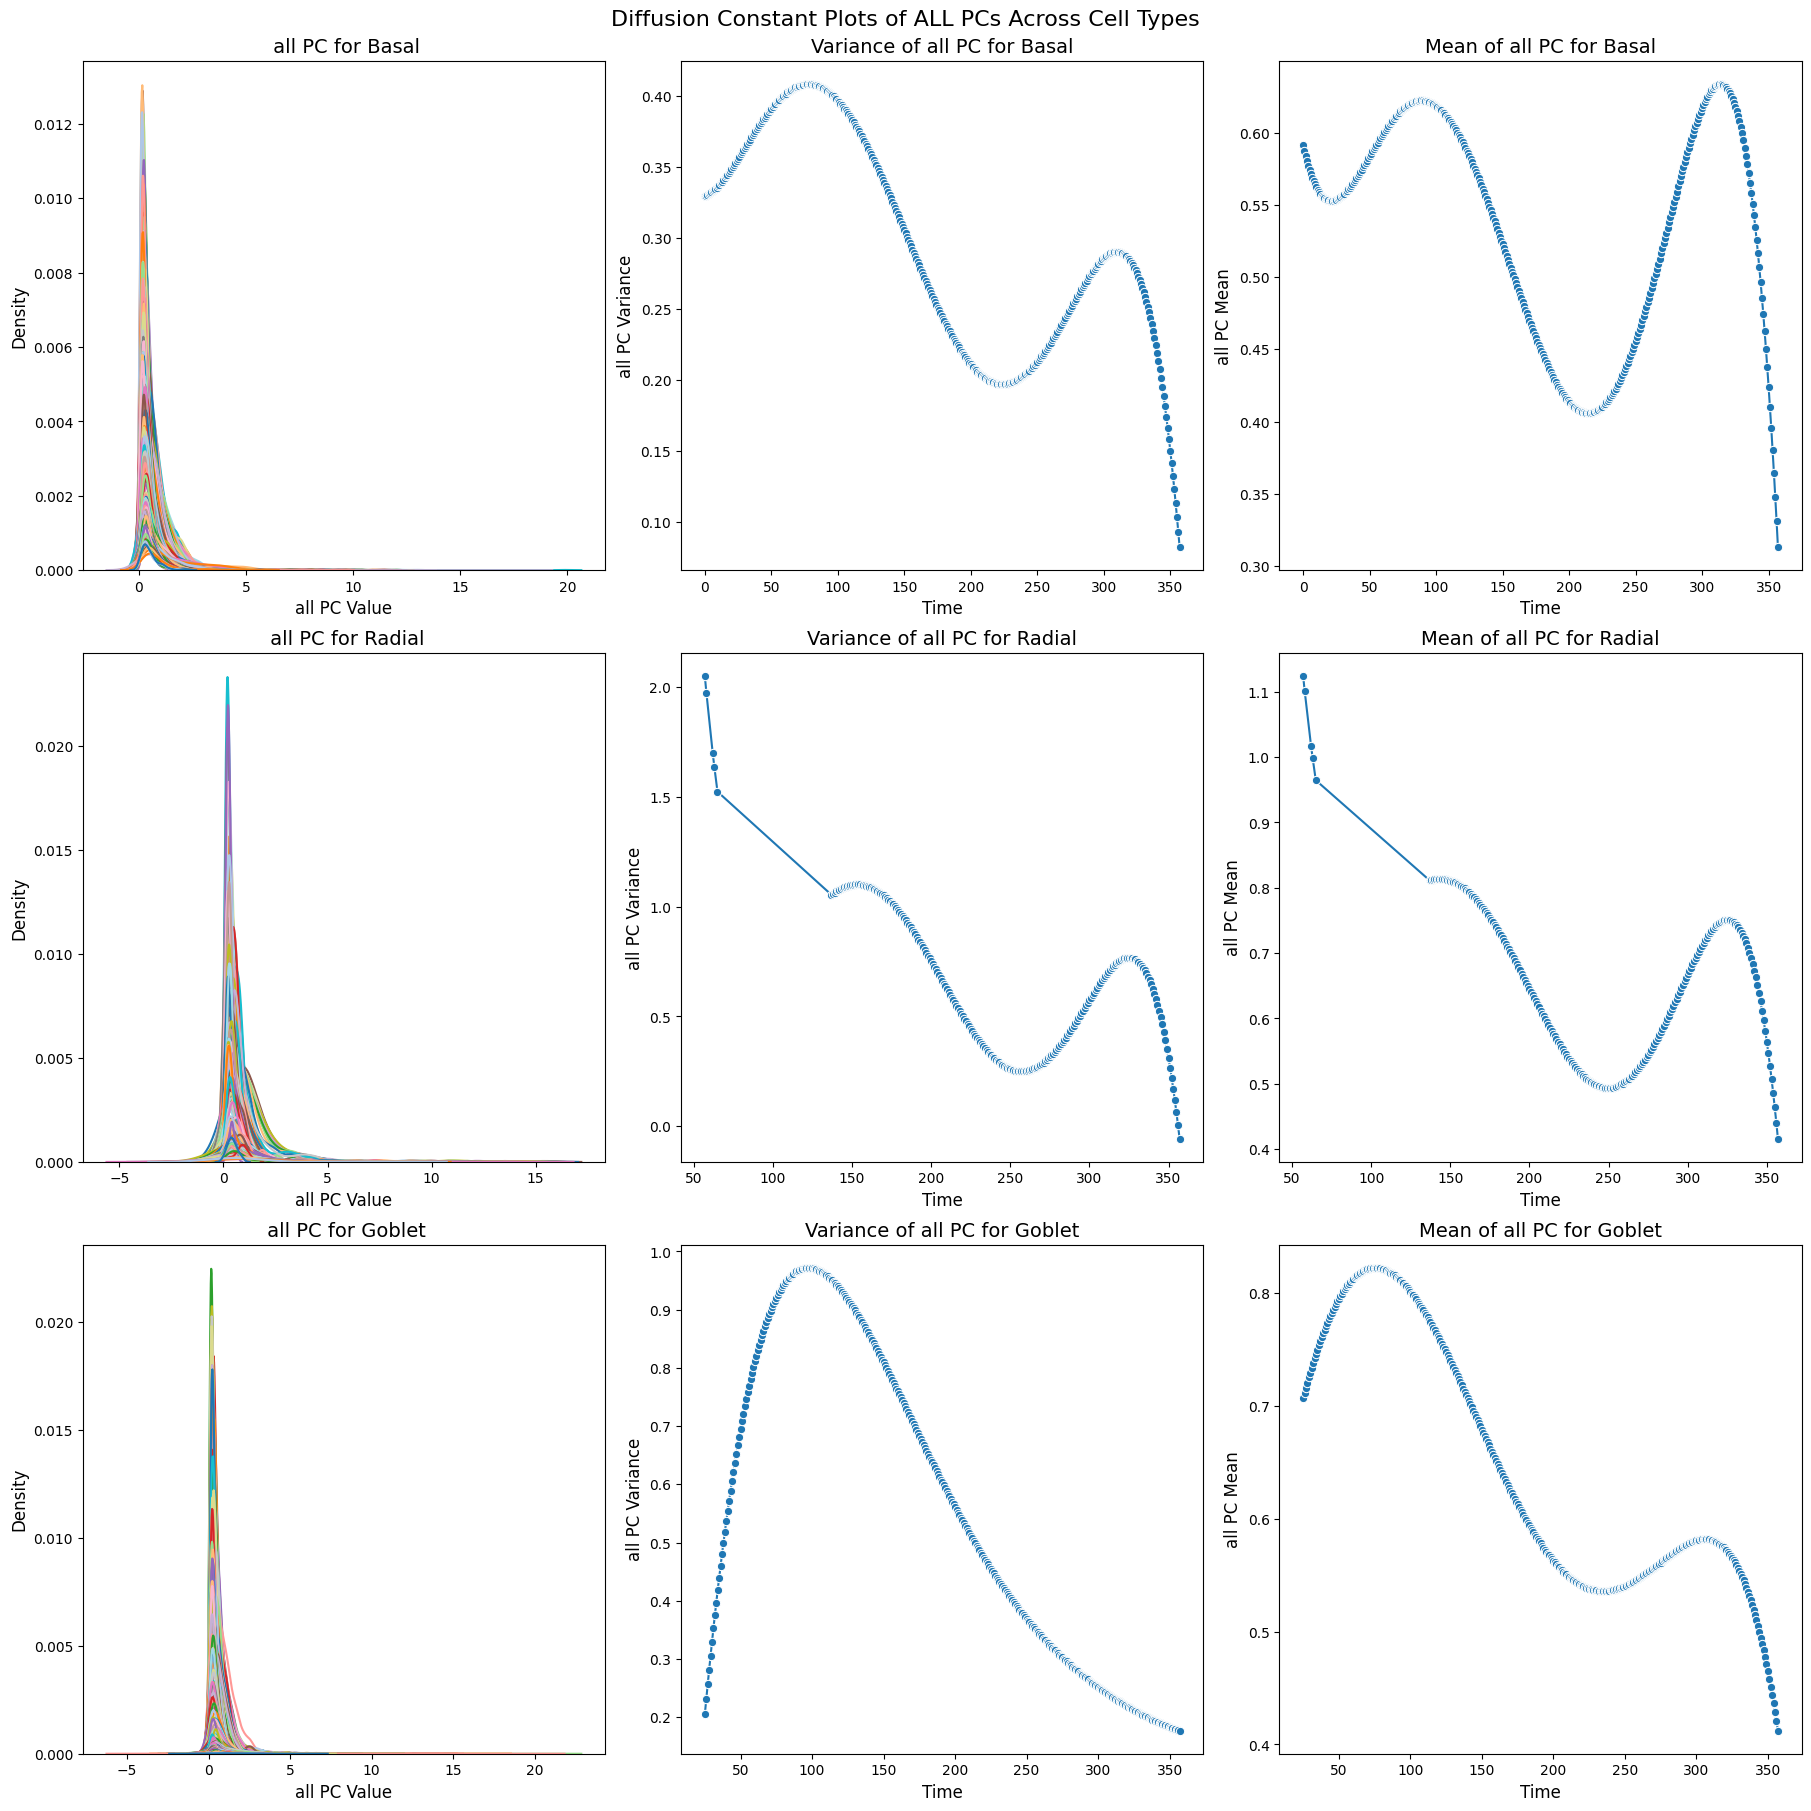

In [61]:

plot_all_pcs_density_and_stats(derivative_dict, title = 'Derivative Plots of ALL PCs Across Cell Types')

plot_all_pcs_density_and_stats(derivative_square_dict, title = 'Diffusion Constant Plots of ALL PCs Across Cell Types')


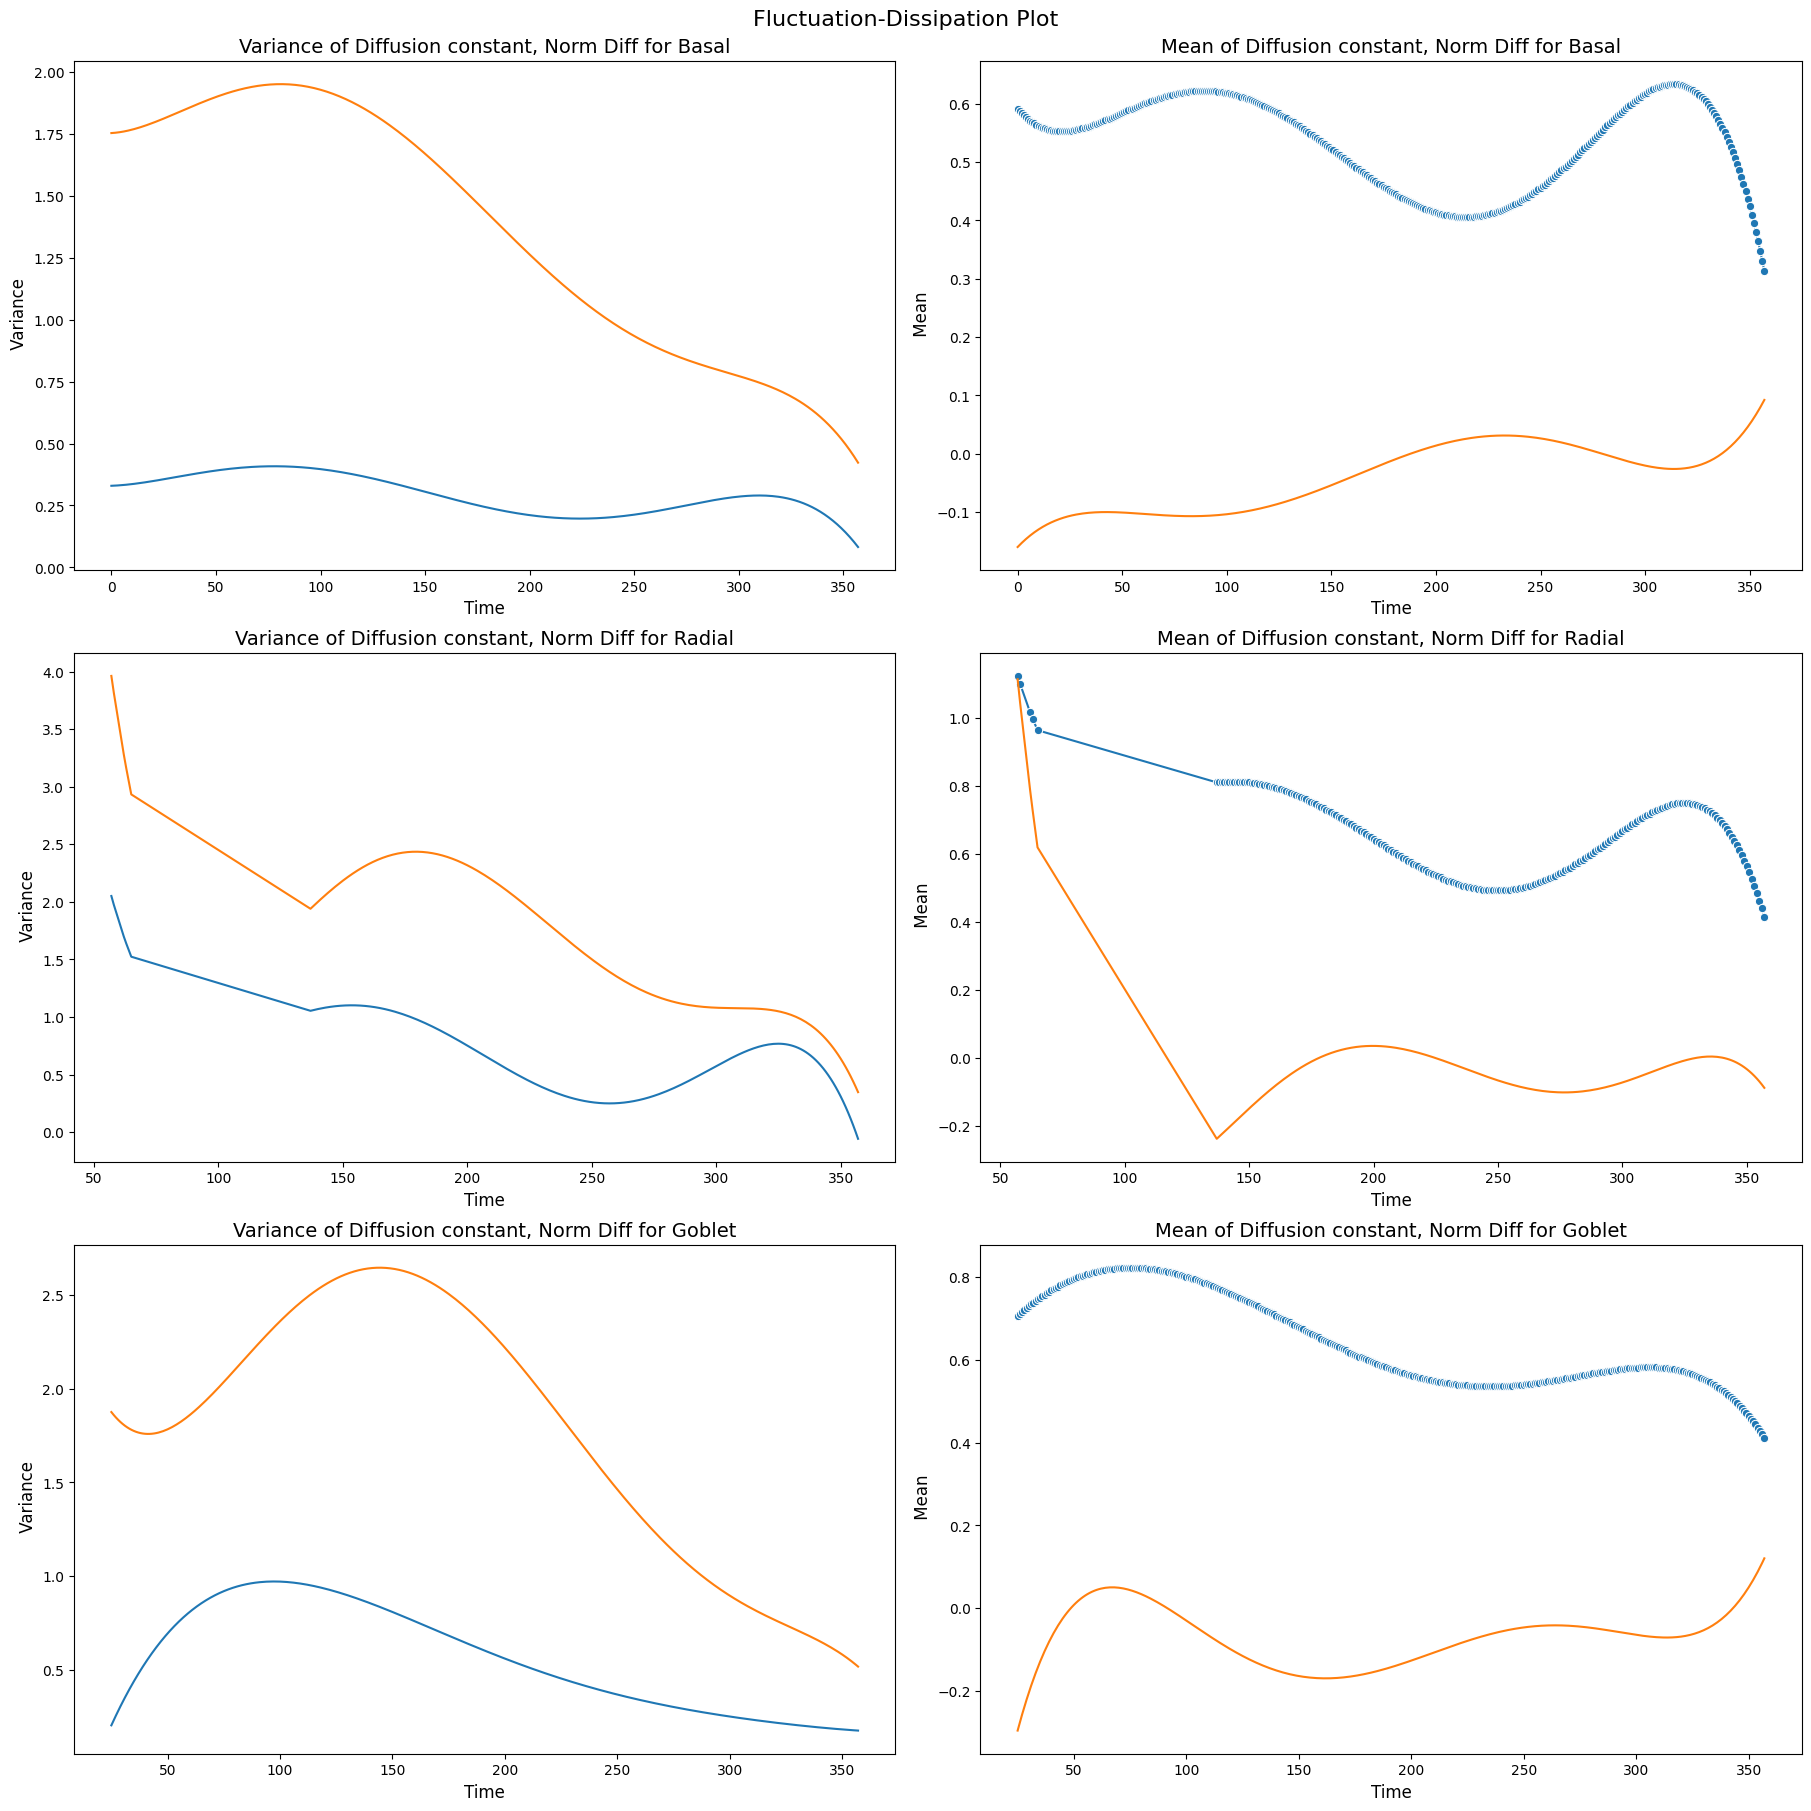

In [60]:
plot_fluctuation_dissipation(derivative_square_dict, norm_diff_dict, title='Fluctuation-Dissipation Plot')